# **The Stokes equations**
**Johan Hoffman**

**Lab made by:** Frida Svelander, \\
**In collaboration with:** Joel Kronborg

# **Abstract**

In this short report I present my solution to the lab on the Stokes equations in the course DD2365/FDD3371 Advanced Computation in Fluid Mechanics at KTH Royal Institute of Technology.. I have used the FEniCS software with Python in Google Colab to solve a set of problems related to the mesh and finite element  stability in 2D channel flow. 

The weak form of the Stokes equations are discretized using a finite element method, with inf-sup stable Taylor-Hood approximation spaces chosen for the trial- and test spaces. We choose piecewise linear continous test and trial functions for the pressure, and piecewise quadratic test and trial functions for the velocity (CG2-CG1). By inspecting the pressure and velocity fields, we verify that a CG1-CG1 mixed method is not stable, but can be stabilized with the Brezzi-Pitkäranta stabilization method.          

The report is based on a template report by Johan Hoffman.


# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$ (1)

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$ (2)

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

We use FEniCS with Python in Google Colab to solve the Stokes equations in 2D channel flow with the finite element method. We first define the triangle mesh with resolution h=1/32 and a circular hole of radius 0.2 at the center of the channel. The mesh is refined once about the circular hole, in a circle of radius 1. We plot the mesh and see the result in Fig. 1.   

**Set up FEniCS environment**

In [1]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB



**Define domain and mesh**

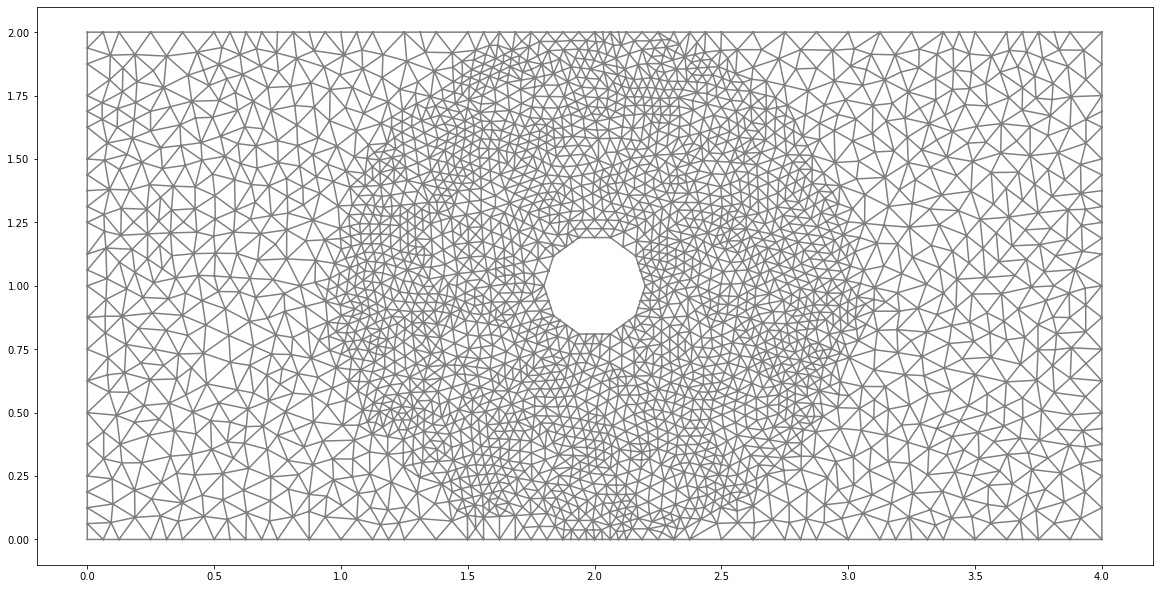

In [2]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh with a circular hole in the center 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1 # changed to 1 to refine once
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L,0.5*H)) < 1.0:  #changed here to Point(0.5*L,0.5*H))
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

#plt.figure()
plt.figure(figsize=(20, 16))
plot(mesh)
plt.show()

**Fig. 1.** *The computational domain is a 2D channel of size 4x2 units, with a circular hole of radius 0.2 located at the center of the channel. The domain is discretized in a triangular mesh, which is refined once around the circular hole.*

**Define finite element approximation spaces**

Next, we define the finite element spaces on which we seek the solution to the variational formulation of the Stokes equations. According to Theorem 7 and 8 in the Lecture Notes by J. Hoffman, our mixed finite element problem (2) has a unique solution if we choose the the approximation space for the velocity sufficiently rich compared to the approximation space for the pressure. This is the inf-sup condition, and is satisfied if we choose the Taylor-Hood CG2-CG1 (velocity-pressure) mixed finite element space for the velocity and pressure.   

In [3]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2) # piecewise quadratic test and trial functions for velocity
# VE = VectorElement("CG", mesh.ufl_cell(), 1) # piecewise linear test and trial functions for velocity
QE = FiniteElement("CG", mesh.ufl_cell(), 1) # piecewise linear test and trial functions for the pressure 
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

Next we define the bouncary conditions for the Stokes problem (1)-(2). We set the inflow velocity to $\frac{4y(2-y)}{4}$, which is a parabolic inflow profile with no-slip velocity at the walls and maximal inflow velocity at the center of the inlet.

In [4]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

To solve the weak equations (2) of the Stokes problem, we set the residual to zero and formulate the residual using FEniCS syntax, where we have multiplied each term with a test function, applied Green's formula and finally integrated both sides of the residual over the domain $\Omega$. The integration is in FEniCS syntax represented by the multiplication of the differential $dx$ or $ds$ to mark integration over the interior and the boundary respectively. We introduce a factor $\texttt{Cstabilization}$ which is zero in the standard case, and set to one as an implementation of the Brezzi-Pitkäranta stabilization method in combination with a CG1 approximation space also for the velocity. 

In [8]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

Cstabilization = 1.0
Cstabilization = 0.0
# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            #Cstabilization*h*h*inner(grad(p), grad(q))*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


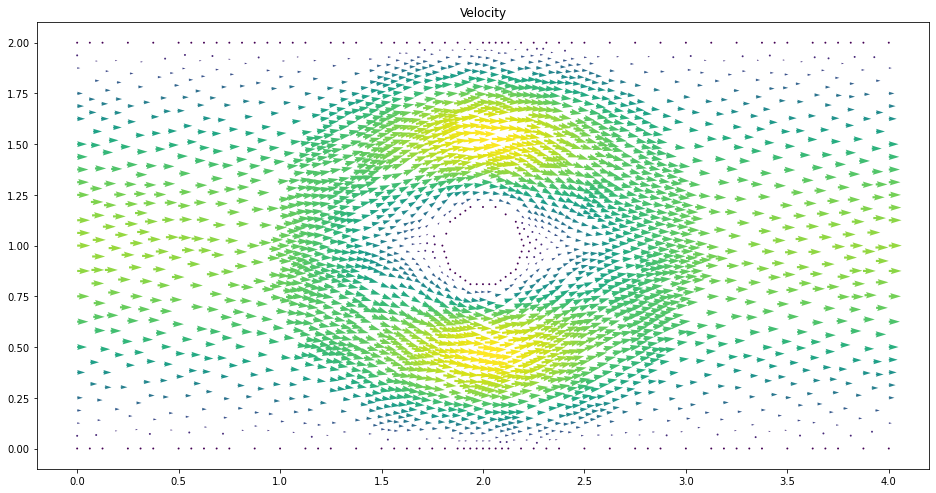

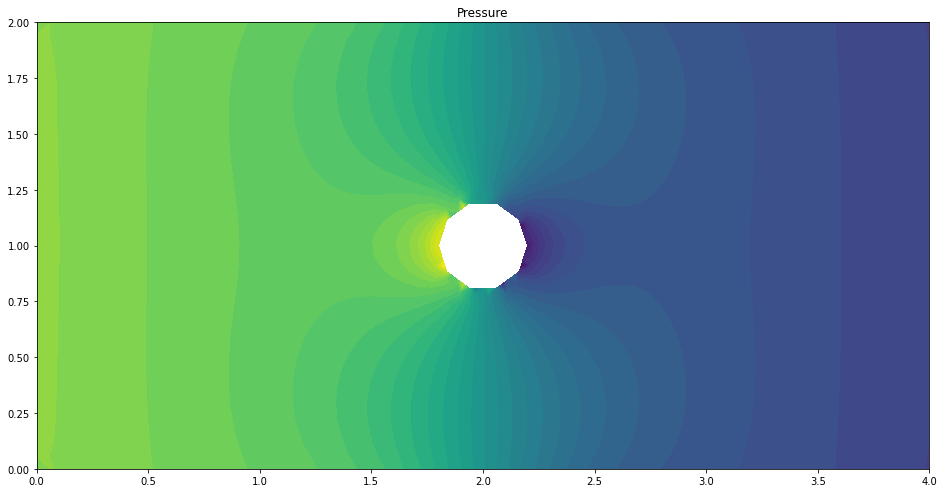

In [9]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure(figsize=(16, 12))
plot(u1, title="Velocity")

plt.figure(figsize=(16, 12))
plot(p1, title="Pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Fig. 2.** (Top) Velocity field in the stabilized CG1-CG1 (Brezzi-Pitkäranta) case plotted over the 2D channel. 

**Fig. 3.** (Bottom) Pressure field in the stabilized CG1-CG1 (Brezzi-Pitkäranta) case plotted over the whole 2D channel. 

In Fig. 2. we see the velocity field for the stabilized Brezzi-Pitkäranta method. We note how the velocity is increased above and below the circular hole according to the continuity criteria. In Fig. 3. we see how the flow is driven from high to low pressure. The smooth transition from high to low pressure indicates that the Brezzi-Pitkäranta stabilization method is working.

In Fig. 4. and Fig. 5. we see the corresponding plots of the pressure in the standard unstabilized CG1-CG1 and CG2-CG1 case respectively. It is obvious from Fig. 4. that the pressure field has areas of unphysically high and unstable pressure close to the circular hole, and is not as smooth as expected when the CG1-CG1 method is not stabilized. The pressure field is smoother in the CG2-CG1 case (Fig. 5.).

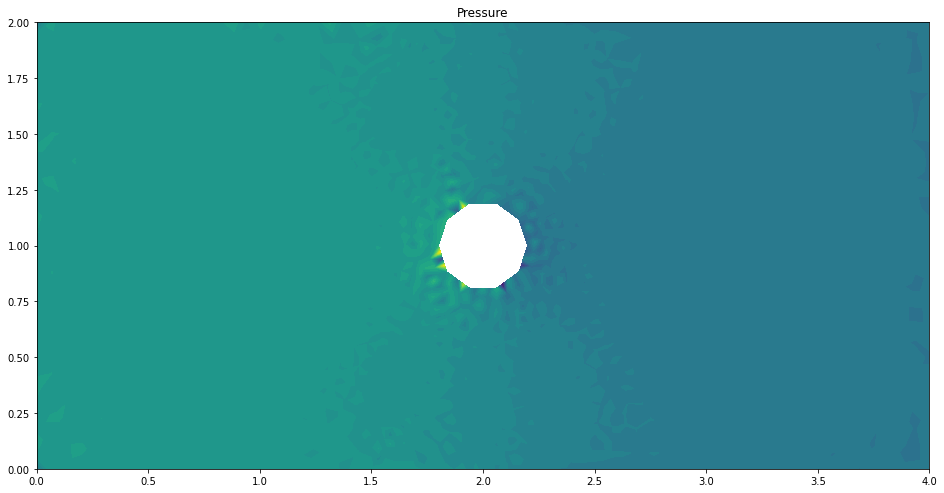

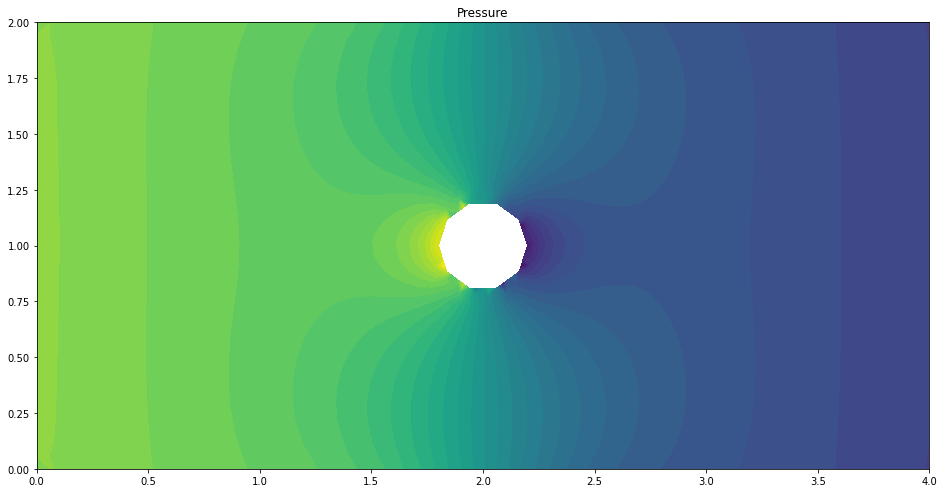

**Fig. 4.** (Top) Pressure field in the standard unstabilized CG1-CG1 case plotted over the 2D channel.

**Fig. 5.** (Bottom) Pressure field in the CG2-CG1 (Taylor-Hood) case plotted over the whole 2D channel.

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a circular cylinder, with satisfactory results reffering to the inf-sup condition. 

Changing to continuous piecewise linear approximation spaces for both velocity and pressure leads, as expected, to an unstable solution which is especially observed in the plot of the pressure field. It is verified that the Brezzi-Pitkäranta method can be used to stabilize the solution when piecewise linear elements are used for both approximation spaces.      